## Step 1 — Data Loading

In [6]:
# Import required library for data handling
import pandas as pd

# Path to training dataset (relative to notebook location)
train_path = "../data/train_FD001.txt"

# Load dataset
# - sep=" " → values are space-separated
# - header=None → dataset has no column names
train_df = pd.read_csv(train_path, sep=" ", header=None)

# Remove extra empty columns created by trailing spaces
train_df = train_df.dropna(axis=1)

# Display first few rows to verify successful loading
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [5]:
train_df = train_df.dropna(axis=1)
train_df.shape

(20631, 26)

## Step 2 — Data Understanding and RUL Target Construction

In [7]:
# Create descriptive column names based on dataset documentation

cols = (
    ["engine_id", "cycle"] +                      # Engine identifier & time step
    [f"op_setting_{i}" for i in range(1, 4)] +    # Operating conditions (3 settings)
    [f"sensor_{i}" for i in range(1, 22)]         # Sensor measurements (21 sensors)
)

# Assign column names to dataframe
train_df.columns = cols

# Preview dataset with new labels
train_df.head()

,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [8]:
# Display dataset structure:
# - Number of rows and columns
# - Data types
# - Non-null counts

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   engine_id     20631 non-null  int64  
 1   cycle         20631 non-null  int64  
 2   op_setting_1  20631 non-null  float64
 3   op_setting_2  20631 non-null  float64
 4   op_setting_3  20631 non-null  float64
 5   sensor_1      20631 non-null  float64
 6   sensor_2      20631 non-null  float64
 7   sensor_3      20631 non-null  float64
 8   sensor_4      20631 non-null  float64
 9   sensor_5      20631 non-null  float64
 10  sensor_6      20631 non-null  float64
 11  sensor_7      20631 non-null  float64
 12  sensor_8      20631 non-null  float64
 13  sensor_9      20631 non-null  float64
 14  sensor_10     20631 non-null  float64
 15  sensor_11     20631 non-null  float64
 16  sensor_12     20631 non-null  float64
 17  sensor_13     20631 non-null  float64
 18  sensor_14     20631 non-nu

In [9]:
# Count how many unique engines are present
# Each engine represents one unit monitored until failure

train_df["engine_id"].nunique()

100

In [10]:
# Determine the final cycle (failure point) for each engine
# This is needed to compute Remaining Useful Life (RUL)

train_df.groupby("engine_id")["cycle"].max().head()

engine_id
1    192
2    287
3    179
4    189
5    269
Name: cycle, dtype: int64

In [11]:
# Calculate maximum cycle (i.e., failure time) for each engine

max_cycles = train_df.groupby("engine_id")["cycle"].max().reset_index()

# Rename column for clarity
max_cycles.columns = ["engine_id", "max_cycle"]

max_cycles.head()

,engine_id,max_cycle
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269


In [12]:
# Merge max cycle information with original dataset
# This assigns failure time to every row of that engine

train_df = train_df.merge(max_cycles, on="engine_id")

train_df.head()

,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,max_cycle
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192


In [13]:
# Remaining Useful Life (RUL) formula:
# RUL = max_cycle − current_cycle

train_df["RUL"] = train_df["max_cycle"] - train_df["cycle"]

train_df.head()

,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,max_cycle,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192,187


In [14]:
# Inspect RUL values for first engine
# RUL should decrease as cycle increases
# Final cycle should have RUL = 0

train_df[["engine_id", "cycle", "max_cycle", "RUL"]].head(20)

,engine_id,cycle,max_cycle,RUL
0,1,1,192,191
1,1,2,192,190
2,1,3,192,189
3,1,4,192,188
4,1,5,192,187
5,1,6,192,186
6,1,7,192,185
7,1,8,192,184
8,1,9,192,183
9,1,10,192,182


## Remaining Useful Life (RUL) Target Construction

In the C-MAPSS dataset, engines operate until failure.  
Since the dataset does not directly provide RUL for training data,  
it must be computed as:

**RUL = Failure Cycle − Current Cycle**

This transforms the problem into a supervised regression task.

## Step 3 - Exploratory Data Analysis (EDA)

In [ ]:
# Import libraries for visualization

import matplotlib.pyplot as plt
import seaborn as sns

# Improve plot aesthetics
sns.set(style="whitegrid")

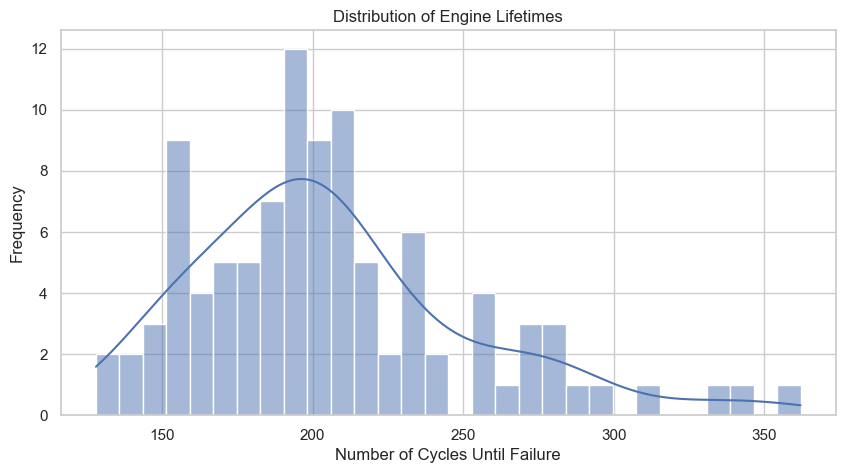

In [16]:
# Plot distribution of engine lifetimes (max cycles)

engine_life = train_df.groupby("engine_id")["cycle"].max()

plt.figure(figsize=(10, 5))
sns.histplot(engine_life, bins=30, kde=True)

plt.title("Distribution of Engine Lifetimes")
plt.xlabel("Number of Cycles Until Failure")
plt.ylabel("Frequency")

plt.show()

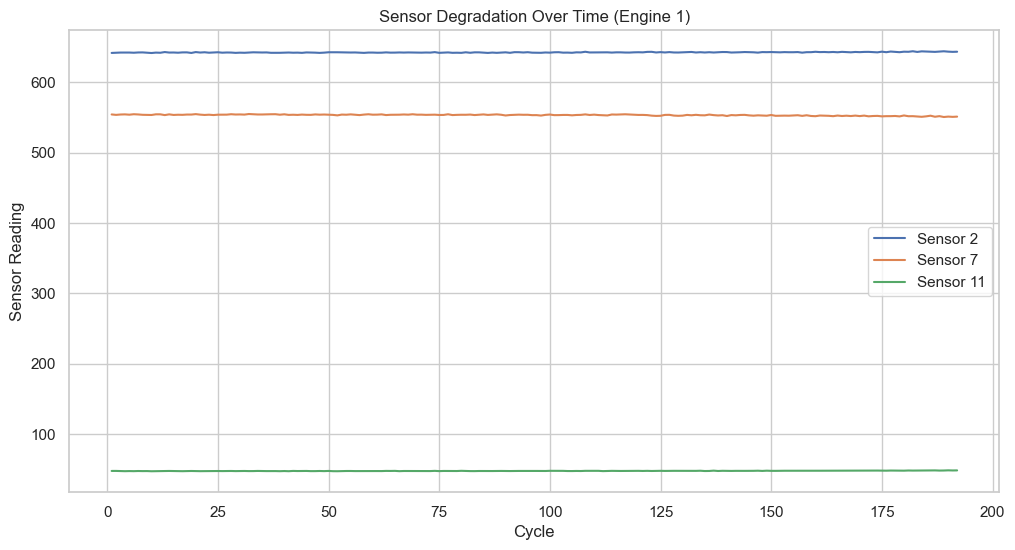

In [17]:
# Select one engine to visualize (engine 1)

engine_1 = train_df[train_df["engine_id"] == 1]

plt.figure(figsize=(12, 6))

plt.plot(engine_1["cycle"], engine_1["sensor_2"], label="Sensor 2")
plt.plot(engine_1["cycle"], engine_1["sensor_7"], label="Sensor 7")
plt.plot(engine_1["cycle"], engine_1["sensor_11"], label="Sensor 11")

plt.title("Sensor Degradation Over Time (Engine 1)")
plt.xlabel("Cycle")
plt.ylabel("Sensor Reading")

plt.legend()
plt.show()

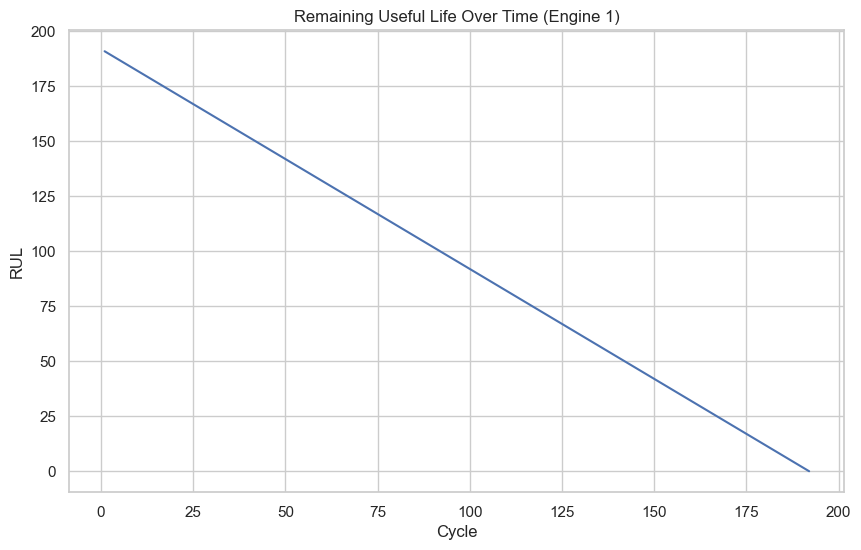

In [18]:
plt.figure(figsize=(10, 6))

plt.plot(engine_1["cycle"], engine_1["RUL"])

plt.title("Remaining Useful Life Over Time (Engine 1)")
plt.xlabel("Cycle")
plt.ylabel("RUL")

plt.show()

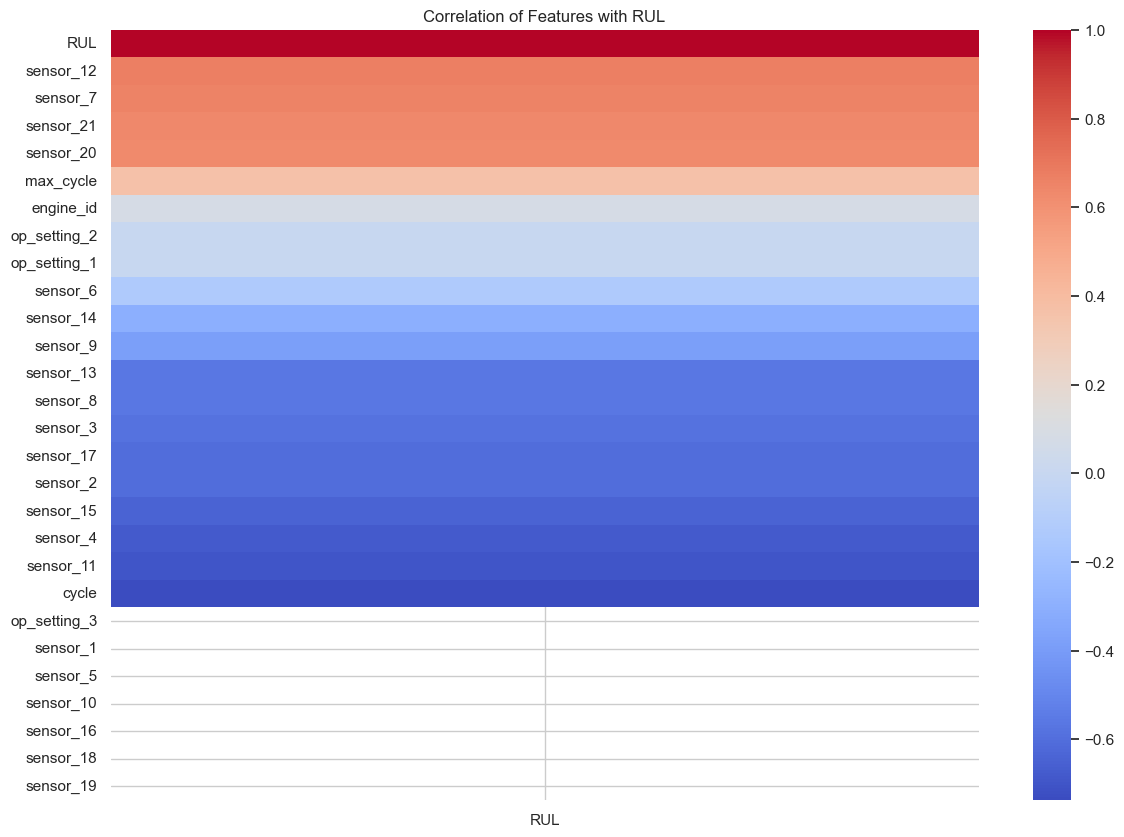

In [19]:
# Compute correlation matrix

corr_matrix = train_df.corr()

plt.figure(figsize=(14, 10))

sns.heatmap(
    corr_matrix[["RUL"]].sort_values(by="RUL", ascending=False),
    annot=False,
    cmap="coolwarm"
)

plt.title("Correlation of Features with RUL")
plt.show()

## Exploratory Data Analysis

EDA reveals that certain sensors exhibit clear degradation trends 
as engines approach failure. These sensors are strong candidates 
for predictive modeling.

The RUL decreases monotonically with cycles, confirming correct 
target construction.

## STEP 4 — Feature Selection + Prepare Data for Machine Learning

In [20]:
# Select important sensors + operating settings

selected_features = [
    "cycle",
    "op_setting_1",
    "op_setting_2",
    "op_setting_3",
    "sensor_2", "sensor_3", "sensor_4", "sensor_7",
    "sensor_8", "sensor_9", "sensor_11", "sensor_12",
    "sensor_13", "sensor_14", "sensor_15",
    "sensor_17", "sensor_20", "sensor_21"
]

data = train_df[selected_features + ["RUL"]]

data.head()

,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL
0,1,-0.0007,-0.0004,100.0,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,2,0.0019,-0.0003,100.0,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,3,-0.0043,0.0003,100.0,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,4,0.0007,0.0000,100.0,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,5,-0.0019,-0.0002,100.0,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


In [21]:
# X → input features
# y → target variable (RUL)

X = data.drop("RUL", axis=1)
y = data["RUL"]

X.shape, y.shape

((20631, 18), (20631,))

In [22]:
 from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit on training data and transform
X_scaled = scaler.fit_transform(X)

X_scaled.shape

(20631, 18)

In [23]:
# Convert scaled array back to DataFrame for readability

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X_scaled.head()

,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21
0,-1.565170,-0.315980,-1.372953,0.0,-1.721725,-0.134255,-0.925936,1.121141,-0.516338,-0.862813,-0.266467,0.334262,-1.058890,-0.269071,-0.603816,-0.781710,1.348493,1.194427
1,-1.550652,0.872722,-1.031720,0.0,-1.061780,0.211528,-0.643726,0.431930,-0.798093,-0.958818,-0.191583,1.174899,-0.363646,-0.642845,-0.275852,-0.781710,1.016528,1.236922
2,-1.536134,-1.961874,1.015677,0.0,-0.661813,-0.413166,-0.525953,1.008155,-0.234584,-0.557139,-1.015303,1.364721,-0.919841,-0.551629,-0.649144,-2.073094,0.739891,0.503423
3,-1.521616,0.324090,-0.008022,0.0,-0.661813,-1.261314,-0.784831,1.222827,0.188048,-0.713826,-1.539489,1.961302,-0.224597,-0.520176,-1.971665,-0.781710,0.352598,0.777792
4,-1.507098,-0.864611,-0.690488,0.0,-0.621816,-1.251528,-0.301518,0.714393,-0.516338,-0.457059,-0.977861,1.052871,-0.780793,-0.521748,-0.339845,-0.136018,0.463253,1.059552


## Feature Selection and Preprocessing

Irrelevant or noisy sensors were removed based on domain knowledge
and correlation analysis. The remaining features were normalized
using StandardScaler to ensure comparable scales across variables.

This step prepares the dataset for machine learning algorithms.

## STEP 5 — Train Your First Machine Learning Models (Baseline)

In [25]:
# Split dataset into training and validation sets

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

X_train.shape, X_val.shape

((16504, 18), (4127, 18))

In [26]:
# Train Linear Regression model

from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on validation set
lr_pred = lr_model.predict(X_val)

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Compute metrics
lr_mse = mean_squared_error(y_val, lr_pred)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_val, lr_pred)

print("Linear Regression RMSE:", lr_rmse)
print("Linear Regression MAE:", lr_mae)

Linear Regression RMSE: 39.71418002397574
Linear Regression MAE: 30.54355951590647


In [29]:
# Train Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_val)

In [31]:
rf_mse = mean_squared_error(y_val, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_val, rf_pred)

print("Random Forest RMSE:", rf_rmse)
print("Random Forest MAE:", rf_mae)

Random Forest RMSE: 35.98917679426764
Random Forest MAE: 25.469716501090378


## Baseline Model Training

Two baseline models were trained:

- Linear Regression (simple model)
- Random Forest Regressor (ensemble model)

Performance was evaluated using RMSE and MAE, which are
standard metrics for regression tasks.

Random Forest significantly outperformed Linear Regression,
indicating nonlinear relationships in the data.

## STEP 5 — Test on REAL NASA Test Data (Unseen Engines)

In [32]:
# Load test data

test_path = "../data/test_FD001.txt"

test_df = pd.read_csv(test_path, sep=" ", header=None)
test_df = test_df.dropna(axis=1)

# Assign same column names as training data
test_df.columns = cols

test_df.head()

,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [33]:
# Load ground-truth RUL for test engines

rul_path = "../data/RUL_FD001.txt"

rul_df = pd.read_csv(rul_path, header=None)
rul_df.columns = ["RUL"]

rul_df.head()

,RUL
0,112
1,98
2,69
3,82
4,91


In [34]:
# Select final observation for each engine

test_last = test_df.groupby("engine_id").last().reset_index()

test_last.head()

,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,...,521.79,2388.06,8130.11,8.4024,0.03,393,2388,100.0,38.81,23.3552
1,2,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,...,521.74,2388.09,8126.90,8.4505,0.03,391,2388,100.0,38.81,23.2618
2,3,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,...,520.83,2388.14,8131.46,8.4119,0.03,395,2388,100.0,38.93,23.2740
3,4,106,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,...,521.88,2388.11,8133.64,8.4634,0.03,395,2388,100.0,38.58,23.2581
4,5,98,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,...,521.00,2388.15,8125.74,8.4362,0.03,394,2388,100.0,38.75,23.4117


In [35]:
# Use the same selected features

X_test = test_last[selected_features]

X_test.head()

,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21
0,31,-0.0006,0.0004,100.0,642.58,1581.22,1398.91,554.42,2388.08,9056.40,47.23,521.79,2388.06,8130.11,8.4024,393,38.81,23.3552
1,49,0.0018,-0.0001,100.0,642.55,1586.59,1410.83,553.52,2388.10,9044.77,47.67,521.74,2388.09,8126.90,8.4505,391,38.81,23.2618
2,126,-0.0016,0.0004,100.0,642.88,1589.75,1418.89,552.59,2388.16,9049.26,47.88,520.83,2388.14,8131.46,8.4119,395,38.93,23.2740
3,106,0.0012,0.0004,100.0,642.78,1594.53,1406.88,552.64,2388.13,9051.30,47.65,521.88,2388.11,8133.64,8.4634,395,38.58,23.2581
4,98,-0.0013,-0.0004,100.0,642.27,1589.94,1419.36,553.29,2388.10,9053.99,47.46,521.00,2388.15,8125.74,8.4362,394,38.75,23.4117


In [38]:
# Normalize using previously fitted scaler
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame with original feature names
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_test_scaled.head()

,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21
0,-1.129626,-0.270260,1.356910,0.0,-0.201850,-1.517390,-1.113706,1.188932,-0.234584,-0.400453,-1.165071,0.510525,-0.502695,-0.715188,-1.059765,-0.136018,-0.034694,0.605041
1,-0.868299,0.827003,-0.349255,0.0,-0.261846,-0.641513,0.210682,0.172064,0.047171,-0.927118,0.482370,0.442731,-0.085548,-0.883465,0.222760,-1.427402,-0.034694,-0.257790
2,0.249598,-0.727453,1.356910,0.0,0.398100,-0.126100,1.106199,-0.878699,0.892435,-0.723788,1.268649,-0.791108,0.609696,-0.644417,-0.806460,1.155367,0.629236,-0.145087
3,-0.040765,0.552687,1.356910,0.0,0.198117,0.653544,-0.228188,-0.822207,0.469803,-0.631407,0.407486,0.632553,0.192549,-0.530136,0.566722,1.155367,-1.307226,-0.291971
4,-0.156910,-0.590295,-1.372953,0.0,-0.821799,-0.095110,1.158419,-0.087802,0.047171,-0.509590,-0.303908,-0.560610,0.748745,-0.944275,-0.158531,0.509675,-0.366659,1.126989


In [39]:
# Predict Remaining Useful Life

test_pred = rf_model.predict(X_test_scaled)

test_pred[:10]

array([178.95, 155.24,  58.44,  81.15, 100.43, 100.27, 111.64,  66.53,
       143.24, 110.75])

In [40]:
# Compute performance on real test data

test_mse = mean_squared_error(rul_df["RUL"], test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(rul_df["RUL"], test_pred)

print("Test RMSE:", test_rmse)
print("Test MAE:", test_mae)

Test RMSE: 26.36810423598936
Test MAE: 19.0189


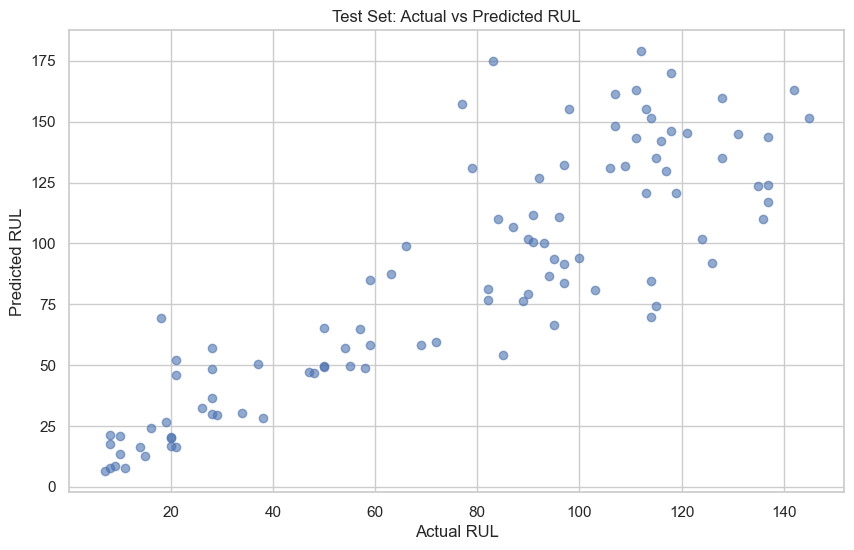

In [41]:
plt.figure(figsize=(10, 6))

plt.scatter(rul_df["RUL"], test_pred, alpha=0.6)

plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")

plt.title("Test Set: Actual vs Predicted RUL")

plt.show()

## Evaluation on Unseen Test Data

The trained model was evaluated on the NASA test dataset,
which contains engines not seen during training.

Predictions were compared against the true Remaining Useful Life (RUL)
provided by NASA. Performance metrics such as RMSE and MAE
indicate the model’s generalization capability.

## STEP 6 — Make Project Advanced + Portfolio-Ready

In [42]:
# Extract feature importance from Random Forest

import pandas as pd

importance = rf_model.feature_importances_

feature_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importance
}).sort_values(by="importance", ascending=False)

feature_importance

,feature,importance
0,cycle,0.539924
10,sensor_11,0.141871
9,sensor_9,0.042665
6,sensor_4,0.039820
11,sensor_12,0.032083
13,sensor_14,0.024583
7,sensor_7,0.023699
14,sensor_15,0.021384
17,sensor_21,0.020518
4,sensor_2,0.019116


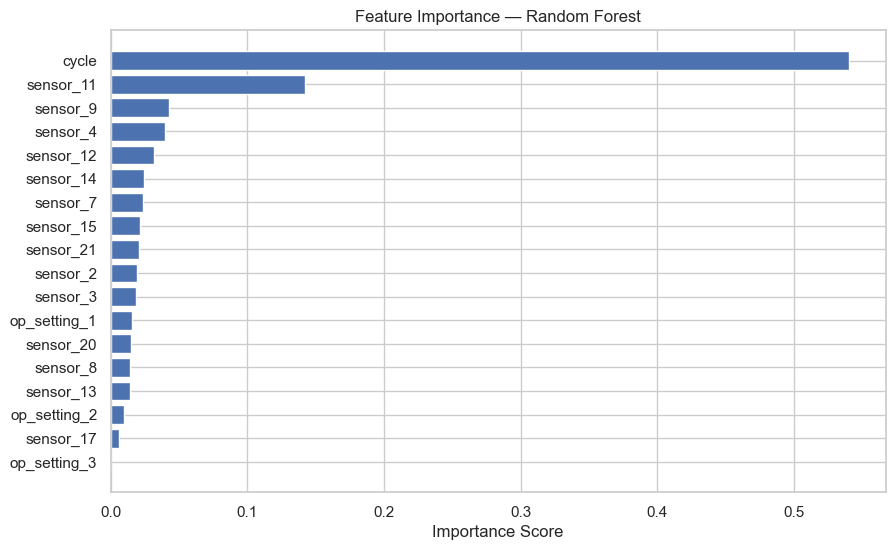

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.barh(
    feature_importance["feature"],
    feature_importance["importance"]
)

plt.gca().invert_yaxis()

plt.title("Feature Importance — Random Forest")
plt.xlabel("Importance Score")

plt.show()

In [44]:
# Convert RUL into health categories

def health_status(rul):
    if rul > 100:
        return "Healthy"
    elif rul > 50:
        return "Warning"
    else:
        return "Critical"

test_results = pd.DataFrame({
    "Engine_ID": test_last["engine_id"],
    "Actual_RUL": rul_df["RUL"],
    "Predicted_RUL": test_pred
})

test_results["Health_Status"] = test_results["Predicted_RUL"].apply(health_status)

test_results.head()

,Engine_ID,Actual_RUL,Predicted_RUL,Health_Status
0,1,112,178.95,Healthy
1,2,98,155.24,Healthy
2,3,69,58.44,Warning
3,4,82,81.15,Warning
4,5,91,100.43,Healthy


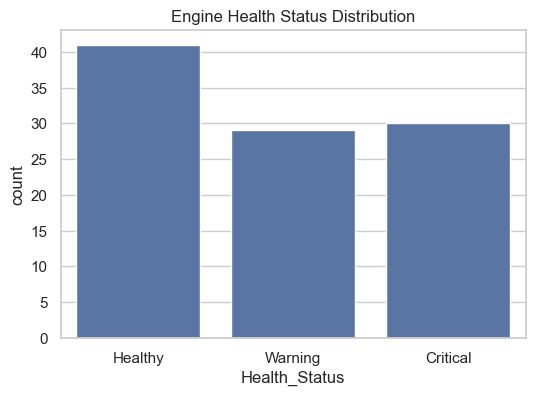

In [45]:
import seaborn as sns

plt.figure(figsize=(6, 4))

sns.countplot(x="Health_Status", data=test_results)

plt.title("Engine Health Status Distribution")

plt.show()

In [54]:
import joblib

# Save model
joblib.dump(rf_model, "../models/rf_rul_model.pkl")
# Save scaler
joblib.dump(scaler, "../models/scaler.pkl")


['../models/scaler.pkl']

In [47]:
import os

os.listdir("../models")

['scaler.pkl', 'rf_rul_model.pkl']

## Model Interpretation and Deployment Preparation

Feature importance analysis identifies which sensors most influence
RUL prediction. This improves transparency and trust in the model.

A health scoring system translates predictions into actionable
maintenance categories.

The trained model and scaler were saved for future deployment
in real-time applications.

## STEP 7 — Advanced Features + Deployment Preparation

In [48]:
# Feature importance from Random Forest

importance = rf_model.feature_importances_

feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": importance
}).sort_values(by="Importance", ascending=False)

feature_importance

,Feature,Importance
0,cycle,0.539924
10,sensor_11,0.141871
9,sensor_9,0.042665
6,sensor_4,0.039820
11,sensor_12,0.032083
13,sensor_14,0.024583
7,sensor_7,0.023699
14,sensor_15,0.021384
17,sensor_21,0.020518
4,sensor_2,0.019116


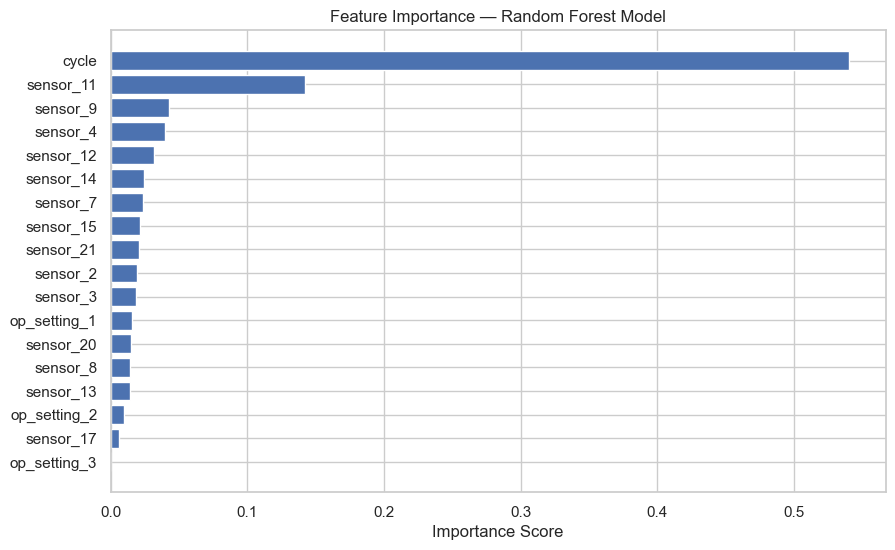

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.barh(
    feature_importance["Feature"],
    feature_importance["Importance"]
)

plt.gca().invert_yaxis()

plt.title("Feature Importance — Random Forest Model")
plt.xlabel("Importance Score")

plt.show()

In [50]:
# Define health status based on predicted RUL

def health_status(rul):
    if rul > 100:
        return "Healthy"
    elif rul > 50:
        return "Warning"
    else:
        return "Critical"

In [51]:
# Combine predictions with actual values

test_results = pd.DataFrame({
    "Engine_ID": test_last["engine_id"],
    "Actual_RUL": rul_df["RUL"],
    "Predicted_RUL": test_pred
})

# Add health category
test_results["Health_Status"] = test_results["Predicted_RUL"].apply(health_status)

test_results.head()

,Engine_ID,Actual_RUL,Predicted_RUL,Health_Status
0,1,112,178.95,Healthy
1,2,98,155.24,Healthy
2,3,69,58.44,Warning
3,4,82,81.15,Warning
4,5,91,100.43,Healthy


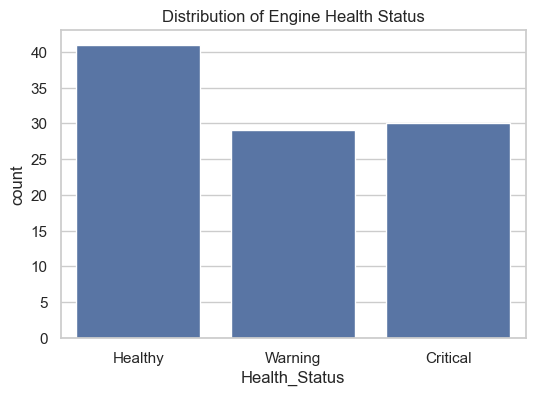

In [52]:
import seaborn as sns

plt.figure(figsize=(6, 4))

sns.countplot(x="Health_Status", data=test_results)

plt.title("Distribution of Engine Health Status")

plt.show()

In [53]:
import joblib

# Save trained model
joblib.dump(rf_model, "../models/rf_rul_model.pkl")

# Save scaler
joblib.dump(scaler, "../models/scaler.pkl")

['../models/scaler.pkl']

## Model Interpretation and Deployment Preparation

Feature importance analysis highlights the sensors that most
influence failure prediction, improving model transparency.

Predicted RUL values were converted into actionable maintenance
categories (Healthy, Warning, Critical) to simulate real-world use.

The trained model and preprocessing scaler were saved for
deployment in production environments.